# Description of problem

Binary classificaiton problem. Predict y=1 for default. 

Variable names are hard to understand => use black box algorithm.

we use auc because...

# TODO

create another method for handling NAs. such as fill with mean, or fill with clustered mean. 

use cloud computing to make the script run faster. 

# Import libraries

In [6]:
# basics :
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import*
import datetime

# custom plot :
import itertools

# scale data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score, classification_report
from sklearn.metrics import classification_report
# save models
from sklearn.externals import joblib

# Read data

In [13]:
raw_data = pd.read_csv('dataset.csv', sep=";")
vardescr = pd.read_csv('variabledescr.csv')

# Clean data

## Method A: fill NA with zeroes and standardize

In [14]:
# create dfp: all rows that have deafult=NA. this df is used for prediction.
dfp = raw_data[pd.isnull(raw_data.default)]
# crate dfm: all rows that have deafult=1 or 0. this df is used for modeling.
dfm = raw_data[pd.notnull(raw_data.default)]

# how many NA?
total_na = dfm.isnull().sum().sum()
total_cells =  dfm.count().sum()
total_na / total_cells * 100

# handle NA in dfm :
dfm = dfm.fillna(0) # fill NA with zero

# Select y for prediction and modeling
yp = dfp['default']
ym = dfm['default']
ym.mean() #concl: 0.014 so very few deafults

# Select X variables
exclude = ['default', 'uuid', 'merchant_category', 'merchant_group', 'name_in_email']
# .info() reveals these are dtype = object so exclude them to save time
Xm = dfm.drop(exclude, axis=1)
Xp = dfp.drop(exclude, axis=1).fillna(0)
ym.shape[0] == Xm.shape[0]

# standardize X
scaler = StandardScaler().fit(Xm)
Xm = scaler.transform(Xm)
Xp = scaler.transform(Xp)

# split into fit and tune
Xf, Xt, yf, yt = train_test_split(Xm, ym, test_size=0.20, random_state=9)

## Method B: fill NA with column mean

We impute the missing value (of variable j) for a certain observation (i,j) with the column mean (mean of j). 

In [16]:
methodb = False
if methodb == True:
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    Xm = imp.fit_transform(Xm)
# todo: continue writing

## Method C: fill NA with clustered column mean

Firstly we divide the data into clusters using k-means clustering. Then we impute the missing value for a certain row's column **j** simply by looking at which group this observation falls into and then replace the missing value with the that group's mean value for **j**. 

In [ ]:
# qq write this code

# Fit and predict all models

We use the following methods:

- Logistic regression
- K Nearest neighbour
- Decision tree

Using 5-fold crossvalidation, we see which model has the highest mean score. 

Which scoring should we use? Either roc_auc or recall. 

Argument for recall: Fraudulent transaction detector (positive class is "fraud"): Optimize for sensitivity because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

Argument for roc_auc: it is the standard method and selects a flexible model. If the AUC for one model is higher we can adjust the threshold in going form proba to classes...

Chose roc_auc

In [17]:
# number of crossvalidation folds:
cv = 5

# select scoring metric
scoring = 'roc_auc'
#scoring = 'recall'

## Logistic regression (reg)

Explanation of what the hyperparameters measures:

* Like the alpha parameter of lasso and ridge regularization, logistic regression also has a regularization parameter: C. C controls the inverse of the regularization strength, and this is what you will tune in this exercise. A large C can lead to an overfit model, while a small C can lead to an underfit model. `param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}`
* penalty... qq write text.


In [18]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid_reg = {'C': c_space, 'penalty': ['l1', 'l2']}
# Instantiate the logistic regression classifier: logreg
reg = LogisticRegression()
# Instantiate the GridSearchCV object
reg_cv = GridSearchCV(reg, param_grid_reg, cv=cv, scoring=scoring)

# Fit it to the training data
load_reg = True# iff you run script for the first time, it should be False.
# load model or fit
if load_reg == True:
    reg_cv = joblib.load("reg_cv.pkl")
else:
    t1 = datetime.datetime.now()
    reg_cv.fit(Xf, yf)
    t2 = datetime.datetime.now()
    reg_td = t2-t1
    print("Fitting time H:MM:SS ", reg_td)
    # save model
    joblib.dump(reg_cv, "reg_cv.pkl")

# Print the optimal parameters and best score
print("reg")
print("Tuned Parameter: {}".format(reg_cv.best_params_))
print("Tuned Accuracy: {}".format(reg_cv.best_score_))
# output: 
# params C = 0.44, penatly = 'l2' (with dfm)
# params C = 0.4394, penalty = 'l1' (with dfm split into Xf Xt)
# score 0.88

reg
Tuned Parameter: {'C': 0.43939705607607948, 'penalty': 'l1'}
Tuned Accuracy: 0.8767331309761568


## Decision tree (tree)

In [20]:
# Setup the parameters
param_dist = {"max_depth": [None, 10, 20, 30], # 30-50% av nr features
              "max_features": [5, 10, 20, 30, Xm.shape[1]],
              "min_samples_leaf": [1, 10, 20, 30, Xm.shape[1]],
              "criterion": ["gini", "entropy"]}
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()
# Instantiate the GridSearchCV() object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=cv, scoring=scoring, n_jobs = -1)

# Fit it to the data
load_tree = True
if load_tree == True:
    tree_cv = joblib.load('tree_cv.pkl')
else:
    t1 = datetime.datetime.now()
    tree_cv.fit(Xf, yf)
    t2 = datetime.datetime.now()
    tree_td = t2-t1
    print("Fitting time H:MM:SS ", tree_td)
    # save model
    joblib.dump(tree_cv, "tree_cv.pkl")

# Print the tuned parameters and score
print("tree")
print("Tuned Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
# output: 
# params are 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 38}
# score 0.84

tree
Tuned Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 38}
Best score is 0.8284158379078223


## K Nearest neighbour (knn)

I WONT EVEN USE KNN BECAUSE I HAPPEN TO KNOW A PRIORI IT TAKE SLONG TIME AND IS BAD, SO I DONT WANT TO WASTE MY TIME RIGHT NOW. MAYBE LATER WHEN PRESENTING A NICE SCRIPT. SO I LEAVE THE CODE AS-IS FROM THE default1_20171129.IPYNB

In [21]:
# set up parameters
k_range = list(range(4, 8))
param_grid = dict(n_neighbors = k_range)
# instantiate
knn = KNeighborsClassifier()
# knn = KNeighborsClassifier(n_neighbors=5)
knn_cv = GridSearchCV(knn, param_grid, cv=cv, scoring=scoring, n_jobs = -1)
# fit
load_knn = True
if load_knn == True:
    knn_cv = joblib.load('knn_cv.pkl')
else:
    t1 = datetime.datetime.now()
    knn_cv.fit(Xm, ym)  # took a long time to run - 1 hour
    t2 = datetime.datetime.now()
    knn_td = t2-t1
    print("Fitting time H:MM:SS ", knn_td)
# examine the best model
print("Tuned parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))
print(knn_cv.best_estimator_)

Tuned parameters: {'n_neighbors': 7}
Best score is 0.6850930867004873
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')


# Compare models

We define best model as highest AUC. Rule of thumb says an AUC > 0.80 is to be considered very good. 

In [22]:
print("reg", reg_cv.best_score_)     
print("tree", tree_cv.best_score_)
print("knn", knn_cv.best_score_)
print("Winning model is: reg")
print("reg details:", reg_cv.best_estimator_)

reg 0.876733130976
tree 0.828415837908
knn 0.6850930867
Winning model is: reg
reg details: LogisticRegression(C=0.43939705607607948, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
# compare classificaiton
print()

plot roc curve of winning model

0.888302823525


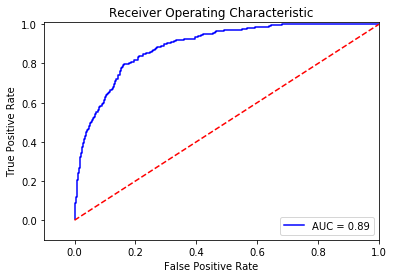

In [23]:
# calculate AUC
penalty = 'l1'
C = 0.4394
reg = LogisticRegression(C = C, penalty = penalty)
y_pred_score = reg.fit(Xf, yf).decision_function(Xt)
fpr, tpr, thresholds = roc_curve(yt, y_pred_score)
roc_auc = auc(fpr,tpr)
print(roc_auc) #is higher than before because now we have entire Xf and before we had cv=5 of Xf

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Threshold

We now have a winning model. Even though the task was to present probabilities, the task in real life is to predict 0 or 1 and act based on that. So we will create a model that is best for this purpose. Given this purpose, we will change the threshold for predict class=1 based on the predicted proba. By default threshold=0.5 but what if being more suspoicious against users and setting a lower threshold of say 0.4 makes the number of defaults lower? 

We will take the winning (highest auc) model from the "fit set" (Xf, yf) and apply it to the "tune set" (Xt, yt). Based on the Xt our model predicts proba. These proba are turned into classifications via a threshold that we vary.  We plot one confusion matrix per threshold. Based on the confusion matrix we chose the threshold that balance FP and FN in a way we believe is optimal for the business.

Define a custom plot

In [24]:
# code from sklearn documentation

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')



NameError: name 'y_test' is not defined

In [25]:
# code from the kaggle page
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Fit, predict, and create confusion matrices

In [49]:
y_pred_proba = reg.predict_proba(Xt)

thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1,0.2,0.3,0.4]

plt.figure(figsize=(10,10))

j = 1
for thresh in thresholds:
    # predict y=1 if proba > threshold 
    y_pred_class = y_pred_proba[:,1] > thresh
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(yt, y_pred_class)
    np.set_printoptions(precision=2)

    #print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    print("Recall & recall", np.round(recall_score(yt, y_pred_class), 3), 
          " & ",
         np.round(precision_score(yt, y_pred_class), 3)
         )

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold > %s'%thresh) 
    
    # plot regular
    print(confusion_matrix(yt, y_pred_class))

Recall & recall 1.0  &  0.019
[[ 4450 13291]
 [    0   255]]
Recall & recall 0.969  &  0.027
[[8942 8799]
 [   8  247]]
Recall & recall 0.922  &  0.037
[[11596  6145]
 [   20   235]]
Recall & recall 0.808  &  0.056
[[14300  3441]
 [   49   206]]
Recall & recall 0.451  &  0.14
[[17037   704]
 [  140   115]]
Recall & recall 0.243  &  0.204
[[17499   242]
 [  193    62]]
Recall & recall 0.098  &  0.25
[[17666    75]
 [  230    25]]
Recall & recall 0.071  &  0.321
[[17703    38]
 [  237    18]]
Recall & recall 0.055  &  0.4
[[17720    21]
 [  241    14]]


# Final predictions

We take the model with the highest AUC above and use that to make prediction on `Xp`.

In [56]:
# instantiate model with optimal parameters
logreg = LogisticRegression(C = 0.44, penalty = 'l2')
# fit on entire modeling dataframe 
logreg.fit(Xm, ym)
# predict 
predictions = logreg.predict_proba(Xp)[:,1]

In [62]:
# save predictions and IDs to csv
predictions = pd.Series(predictions, name = "pred")
IDlist = pd.Series(dfp['uuid'])
#predictions_IDlist = pd.concat([predictions, IDlist], axis=1, ignore_index=True)
predictions_IDlist = pd.concat([predictions, IDlist], axis=1)
print(predictions_IDlist.head())
len(predictions), len(dfp.uuid)

       pred uuid
0  0.013024  NaN
1  0.014024  NaN
2  0.000119  NaN
3  0.032147  NaN
4  0.078474  NaN


(10000, 10000)

ValueError: Can only tuple-index with a MultiIndex

# Future work

build a neural network

# Neural network

qq change the code below. it is for neural netw with train test split, i want cv=5. and roc_auc not accuracy. 

In [1]:

# keras for neural networks:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical


# coding: utf-8

# In[19]:

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from numpy import*
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping


X_train, X_test, Y_train, Y_test= train_test_split(Xm, Ym, random_state=4)


# In[22]:

# create model
model = Sequential()
model.add(Dense(16, input_dim=25, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# In[30]:

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# In[31]:

# # Early stopping
# early_stopping_monitor = EarlyStopping(patience = 3)


# In[32]:

# Fit the model
model.fit(X_train, Y_train, epochs=50, batch_size=64)


# In[33]:

model.summary()


# In[34]:

# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# In[ ]:

ModuleNotFoundError: No module named 'keras'